In [157]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from eofs.multivariate.standard import MultivariateEof
from sklearn.preprocessing import StandardScaler, power_transform
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from eofs.standard import Eof


Loading the Data from previously generated HAFS Output

In [ ]:
with open("CompleteData/all_frames200.pkl", "rb") as f:
    loaded_data = pickle.load(f)

with open('CompleteData/all_frames_100to100.pkl', 'rb') as f:
        loaded_data100 = pickle.load(f)

with open('CompleteData/all_frames_200to200.pkl', 'rb') as f:
        loaded_data200 = pickle.load(f)

Initial Data Analysis

In [ ]:
total_samples = len(loaded_data['center_pressure']) + len(loaded_data100['center_pressure']) + len(loaded_data200['center_pressure'])
print(f'There are {total_samples} samples' )

In [ ]:
# Have to do some cleaning to collapse data into 1d arrays

center_pressure = np.concatenate([loaded_data['center_pressure'], loaded_data100['center_pressure'], loaded_data200['center_pressure']])
gh = np.concatenate([loaded_data['gh'], loaded_data100['gh'], loaded_data200['gh'],])
t = np.concatenate([loaded_data['t'], loaded_data100['t'], loaded_data200['t'],])
rh = np.concatenate([loaded_data['r'], loaded_data100['r'], loaded_data200['r']])
radius = np.concatenate([loaded_data['radius_coords']])[0]
angle = np.concatenate([loaded_data['angle_coords']])[0]


In [ ]:
plt.hist(center_pressure)
plt.xlabel('Minimum Central Pressure')

In [ ]:
gh_clean = []
t_clean = []
rh_clean = []
center_pressure_clean = []

drop_frames = []
for i in range(101):
    if (np.sum(np.isnan(gh[i,:,:]), axis = None)
        or np.sum(np.isnan(t[i,:,:]), axis = None)
        or np.sum(np.isnan(rh[i,:,:]), axis = None)):
        print(f"Frame {i} has NaNs")
    else:
        gh_clean.append(gh[i,:,:])
        rh_clean.append(rh[i,:,:])
        t_clean.append(t[i,:,:])
        center_pressure_clean.append(center_pressure[i])

gh_clean = np.concatenate([gh_clean])
rh_clean = np.concatenate([rh_clean])
t_clean = np.concatenate([t_clean])
center_pressure_clean = np.concatenate([center_pressure_clean])

In [ ]:
# Deciding on scalers

# for reshaping
total_samples = len(center_pressure_clean)
radius_dim = len(radius)
angle_dim = len(angle)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))

ax[0].hist(gh_clean.reshape(total_samples * radius_dim * angle_dim))
ax[1].hist(t_clean.reshape(total_samples * radius_dim * angle_dim))
ax[2].hist(rh_clean.reshape(total_samples * radius_dim * angle_dim))

ax[0].set_title('Geopotential Height Distributions')
ax[1].set_title('Temperature Distributions')
ax[2].set_title('Relative Humidity Distributions')

gh_skew = scipy.stats.skew(gh_clean.reshape(total_samples * radius_dim * angle_dim))
t_skew = scipy.stats.skew(t_clean.reshape(total_samples * radius_dim * angle_dim))
rh_skew = scipy.stats.skew(gh_clean.reshape(total_samples * radius_dim * angle_dim))

ax[0].text(x = 2800, y = 10**7,  s = f'Skewness :{gh_skew}')
ax[1].text(x = 287, y = 1.2 * 10**7, s = f'Skewness :{t_skew}')
ax[2].text(x = 20, y = .8 * 10**7, s = f'Skewness :{rh_skew}')

In [115]:


# Normalizing the Data
scaler = StandardScaler()
gh_std = power_transform(gh_clean.reshape((total_samples, angle_dim*radius_dim))).reshape((total_samples, angle_dim, radius_dim)) 
rh_std = power_transform(rh_clean.reshape((total_samples, angle_dim*radius_dim))).reshape((total_samples, angle_dim, radius_dim)) 
t_std = scaler.fit_transform(t_clean.reshape((total_samples, angle_dim*radius_dim))).reshape((total_samples, angle_dim, radius_dim)) 

Text(-4, 6000000, 'Skewness :-0.8101348280906677')

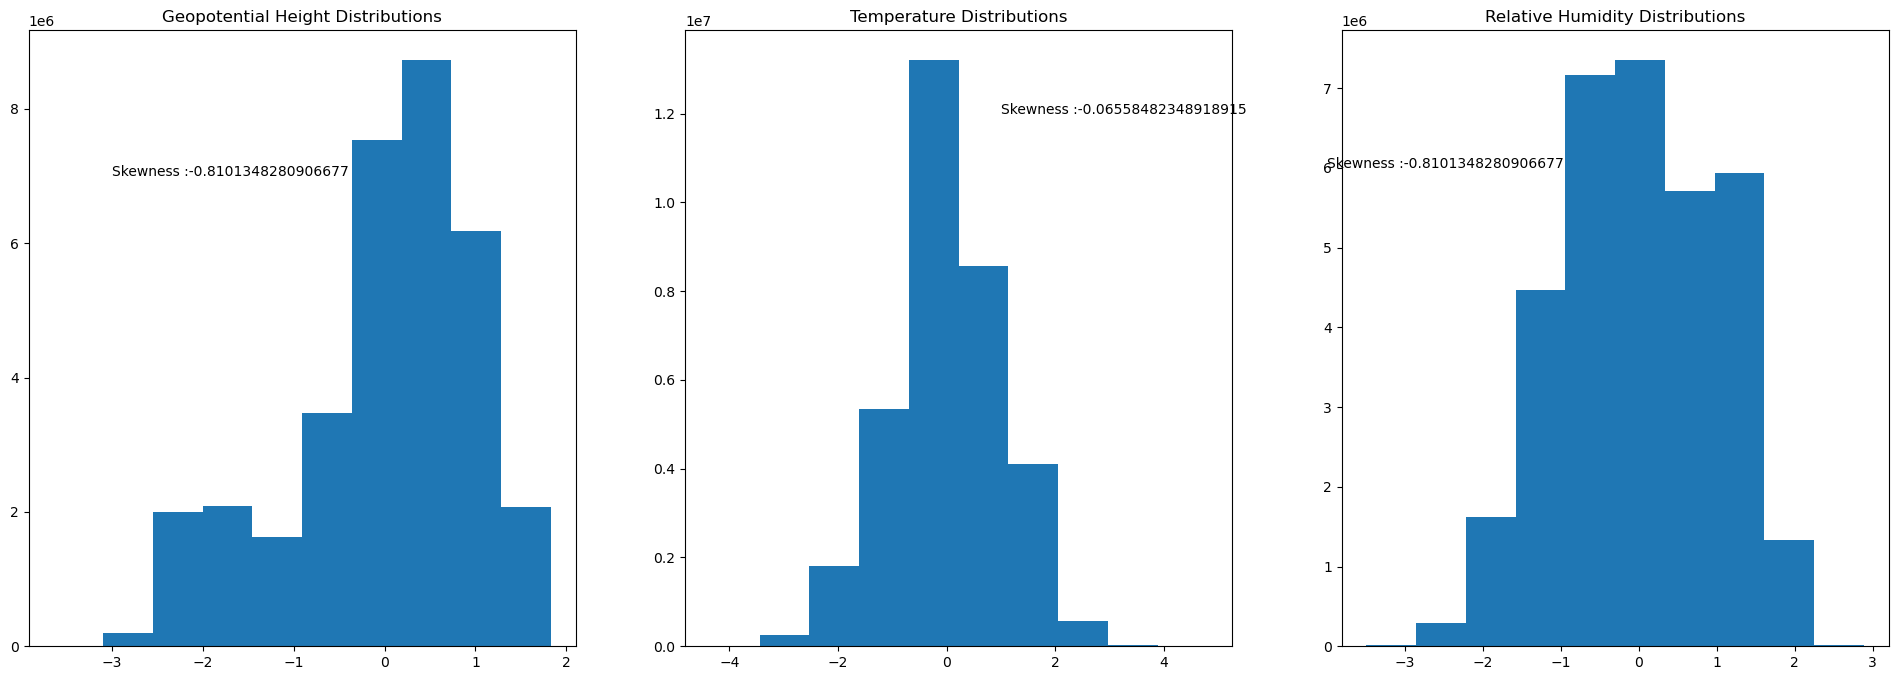

In [ ]:
# for reshaping
total_samples = len(center_pressure_clean)
radius_dim = len(radius)
angle_dim = len(angle)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))

ax[0].hist(gh_std.reshape(total_samples * radius_dim * angle_dim))
ax[1].hist(t_std.reshape(total_samples * radius_dim * angle_dim))
ax[2].hist(rh_std.reshape(total_samples * radius_dim * angle_dim))

ax[0].set_title('Geopotential Height Distributions')
ax[1].set_title('Temperature Distributions')
ax[2].set_title('Relative Humidity Distributions')

gh_skew = scipy.stats.skew(gh_std.reshape(total_samples * radius_dim * angle_dim))
t_skew = scipy.stats.skew(t_std.reshape(total_samples * radius_dim * angle_dim))
rh_skew = scipy.stats.skew(gh_std.reshape(total_samples * radius_dim * angle_dim))

ax[0].text(x = -3, y = 7*10**6,  s = f'Skewness :{gh_skew}')
ax[1].text(x = 1, y = 1.2 * 10**7, s = f'Skewness :{t_skew}')
ax[2].text(x = -4, y = 6 * 10**6, s = f'Skewness :{rh_skew}')


In [124]:
# indexes based on pressure

index_985 = np.where(center_pressure_clean >= 980)
index_980_960 = np.where((980 > center_pressure_clean) & (center_pressure_clean >= 960))
index_960 = np.where((960 > center_pressure_clean))

In [125]:
#creating composites based on pressure ranges

gh_980 = np.nanmean(gh_clean[index_985], axis = 0)
t_980 = np.nanmean(t_clean[index_985], axis = 0)
rh_980 = np.nanmean(rh_clean[index_985], axis = 0)
gh_980_960 = np.nanmean(gh_clean[index_980_960], axis = 0)
t_980_960 = np.nanmean(t_clean[index_980_960], axis = 0)
rh_980_960 = np.nanmean(rh_clean[index_980_960], axis = 0)
gh_960 = np.nanmean(gh_clean[index_960], axis = 0)
t_960 = np.nanmean(t_clean[index_960], axis = 0)
rh_960 = np.nanmean(rh_clean[index_960], axis = 0)

Text(0.5, 0.98, 'Tropical Cyclone Variable Composites based on Minimum Central Pressure')

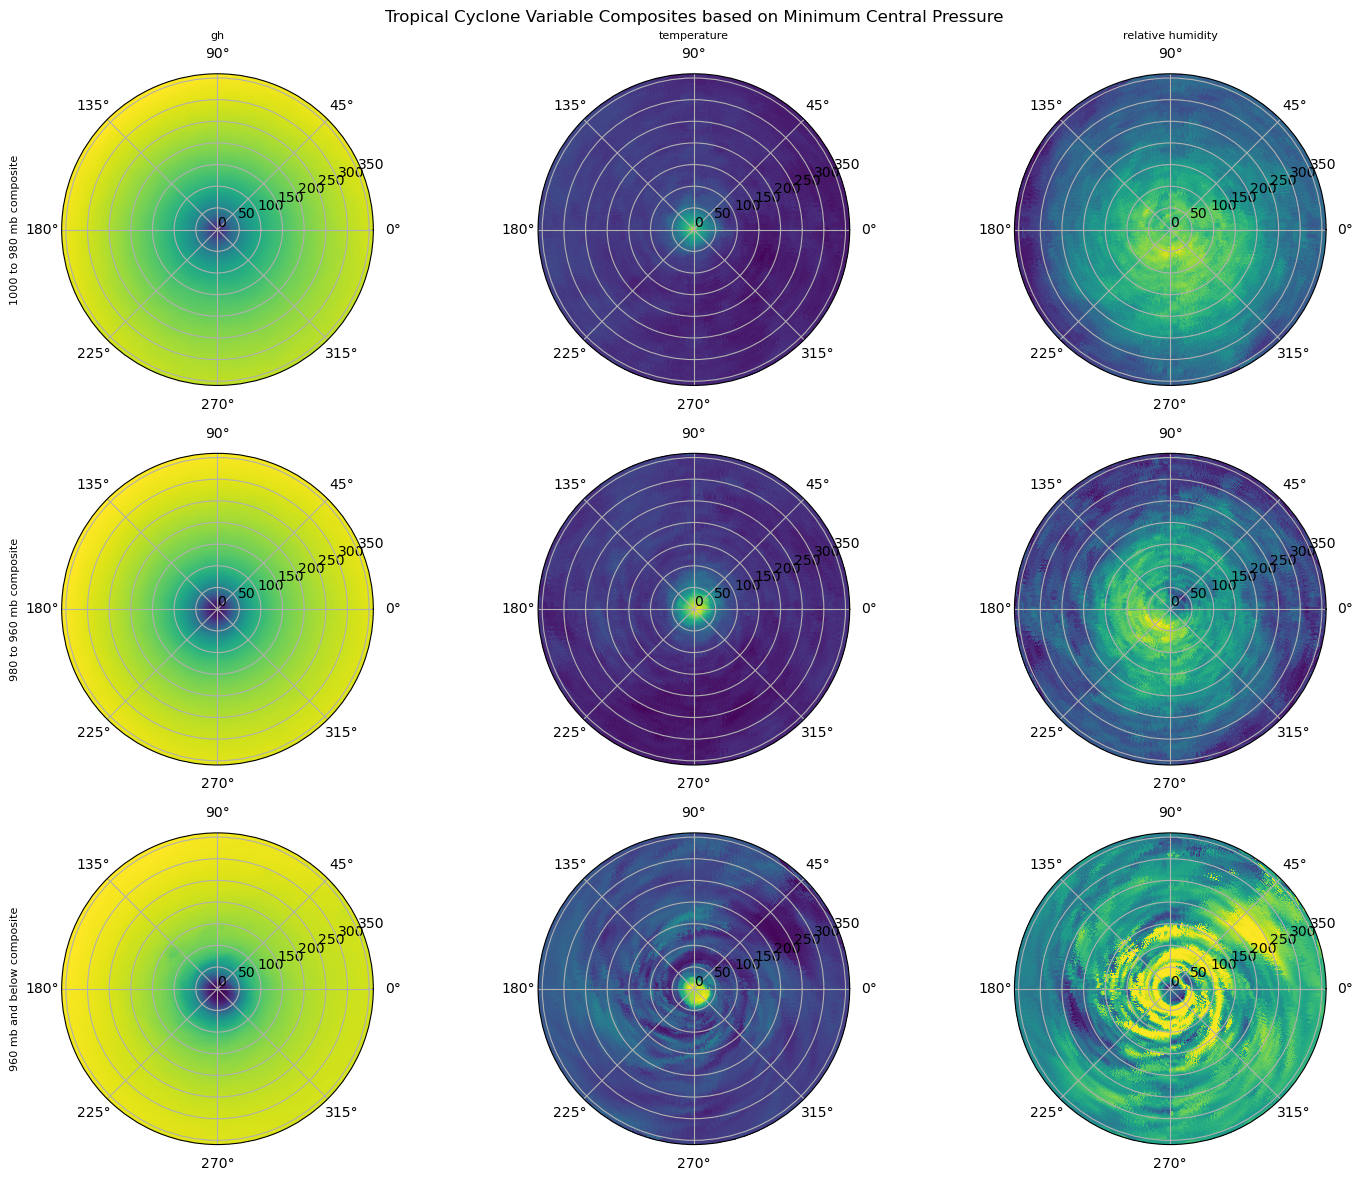

In [126]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_980)
ax[0,1].pcolormesh(R, Theta, t_980)
ax[0,2].pcolormesh(R, Theta, rh_980)
ax[1,0].pcolormesh(R, Theta, gh_980_960)
ax[1,1].pcolormesh(R, Theta, t_980_960)
ax[1,2].pcolormesh(R, Theta, rh_980_960)
ax[2,0].pcolormesh(R, Theta, gh_960)
ax[2,1].pcolormesh(R, Theta, t_960)
ax[2,2].pcolormesh(R, Theta, rh_960)

ax[0,0].set_ylabel('1000 to 980 mb composite', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('980 to 960 mb composite', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('960 mb and below composite', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('Tropical Cyclone Variable Composites based on Minimum Central Pressure')

Calculating weights and constructing EOFs

In [128]:
max_range = 250.0
range_step = 0.5
angle_step = 0.5
range_gates = np.arange(0.0, max_range + range_step, range_step)

areas = []

for i, r in enumerate(range_gates):
    
    area = (angle_step/360) * np.pi * ((r + range_step)**2 - r**2)
    areas.append(area)

area_weight = areas/np.max(areas)

In [ ]:
msolver = MultivariateEof([gh_std,t_std,rh_std], weights=[area_weight, area_weight, area_weight])
gh_eof, t_eof, rh_eof = msolver.eofsAsCovariance(neofs=10)

In [178]:
pcs = msolver.pcs(npcs = 3)

Text(0.5, 0.98, 'First 3 EOFs for a Multivariate EOF consisting of gh, Temp, and RH')

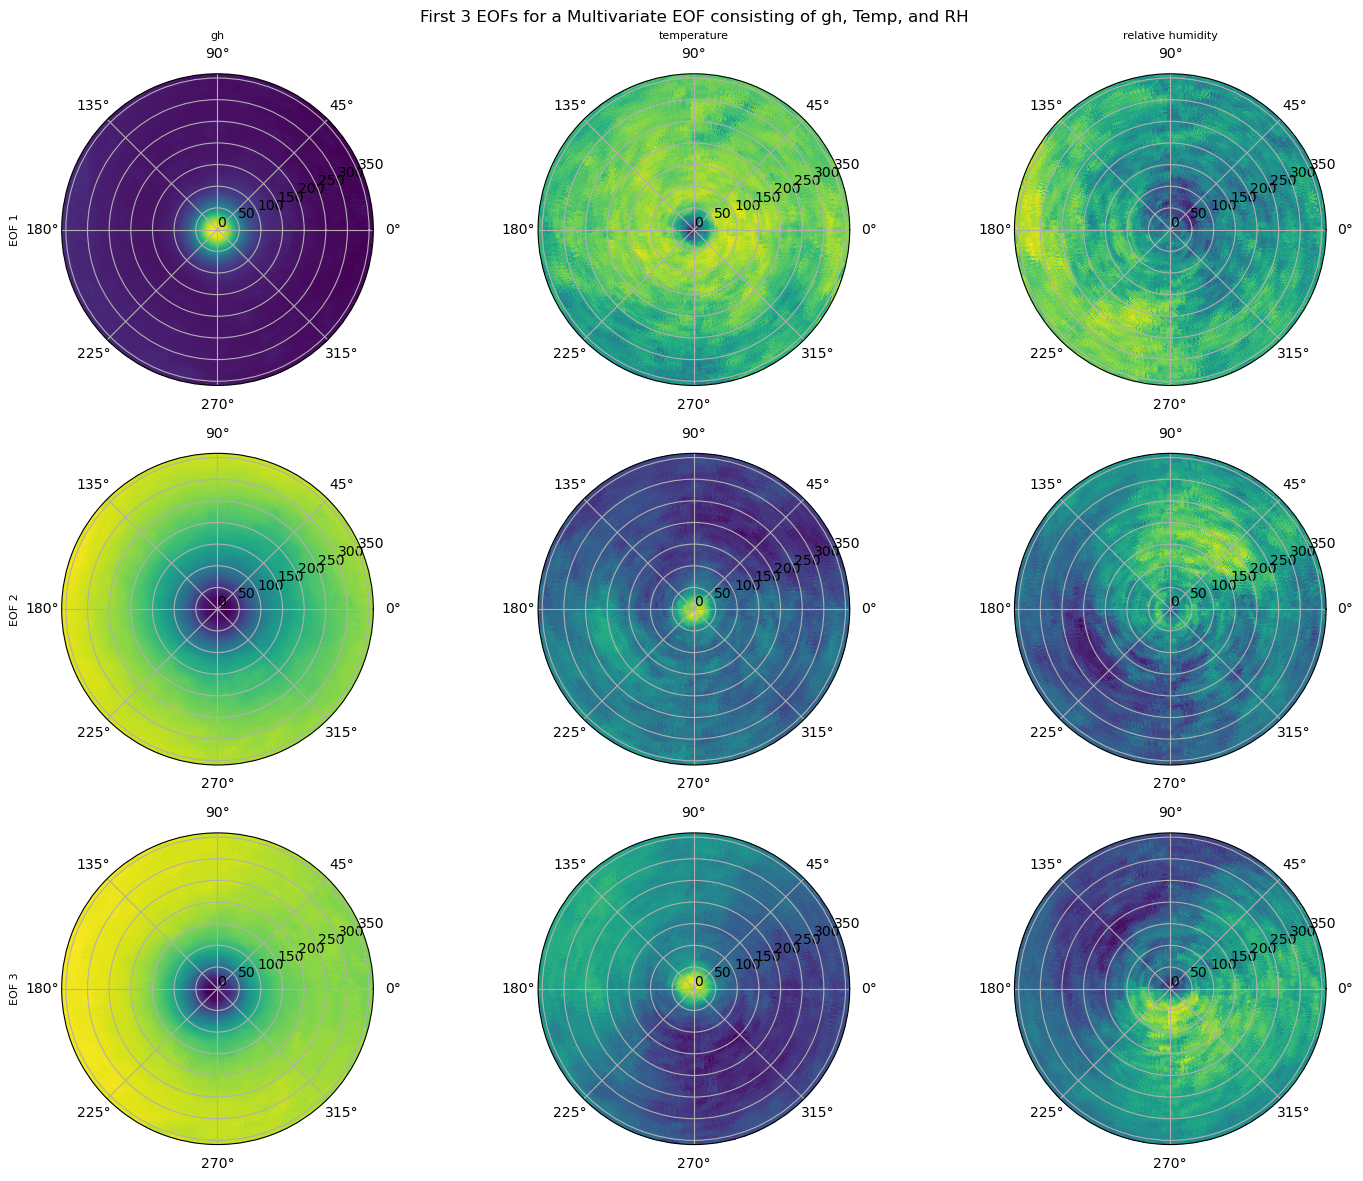

In [179]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_eof[0,:,:])
ax[0,1].pcolormesh(R, Theta, t_eof[0,:,:])
ax[0,2].pcolormesh(R, Theta, rh_eof[0,:,:])
ax[1,0].pcolormesh(R, Theta, gh_eof[1,:,:])
ax[1,1].pcolormesh(R, Theta, t_eof[1,:,:])
ax[1,2].pcolormesh(R, Theta, rh_eof[1,:,:])
ax[2,0].pcolormesh(R, Theta, gh_eof[2,:,:])
ax[2,1].pcolormesh(R, Theta, t_eof[2,:,:])
ax[2,2].pcolormesh(R, Theta, rh_eof[2,:,:])

ax[0,0].set_ylabel('EOF 1', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('EOF 2', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('EOF 3', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('First 3 EOFs for a Multivariate EOF consisting of gh, Temp, and RH')

Text(0.5, 0, 'EOF number')

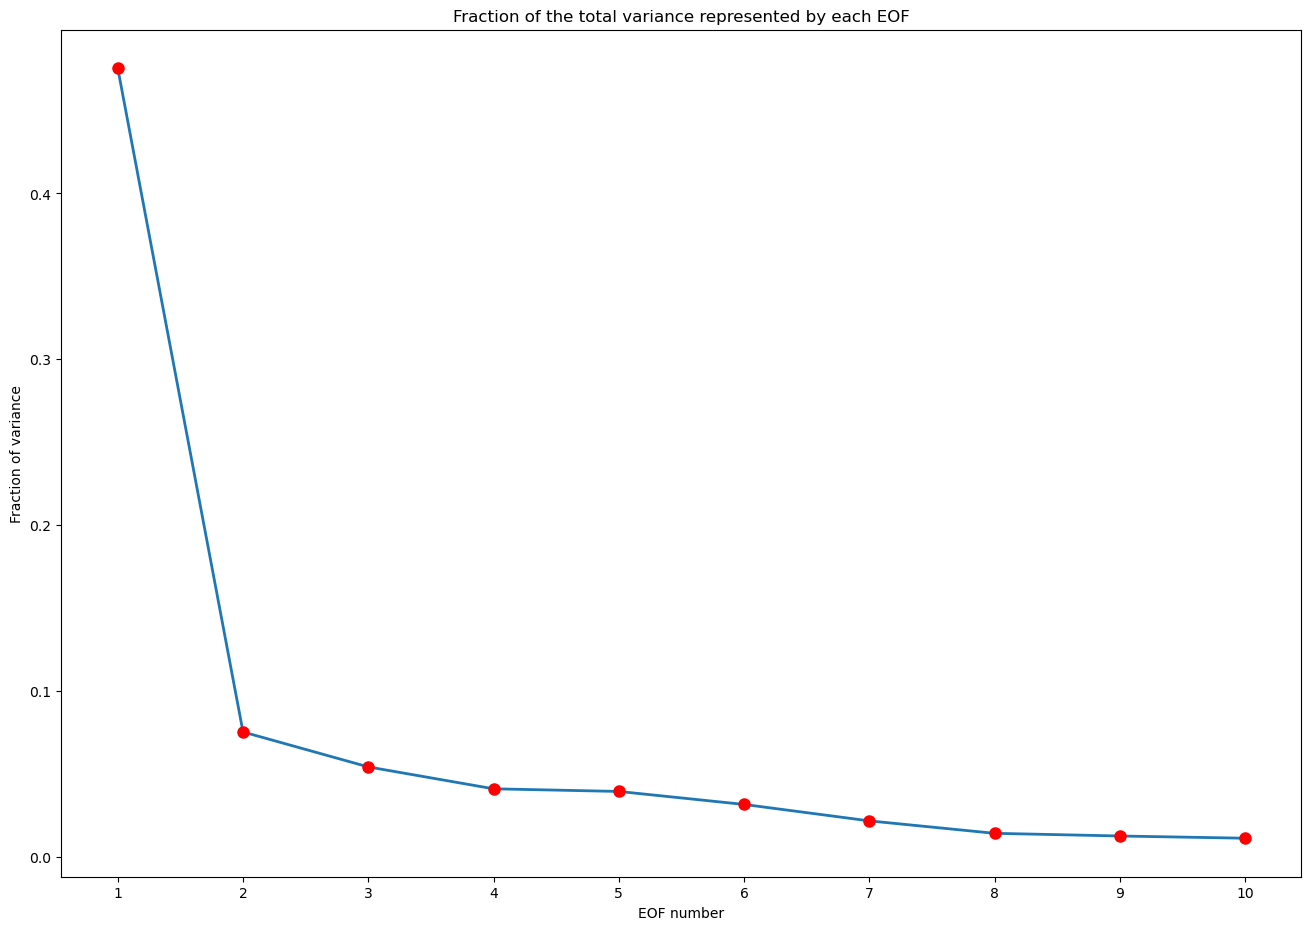

In [180]:
# Looking at the Variance

varfrac = msolver.varianceFraction()

# Plot the fraction of variance explained by each EOF

plt.figure(figsize = (16,11))
eof_num = range(1,11)
plt.plot(eof_num, varfrac[0:10], linewidth = "2")
plt.plot(eof_num, varfrac[0:10], linestyle = "None", marker = "o", color = "r", markersize = 8)
plt.xticks(range(1,11))
plt.title("Fraction of the total variance represented by each EOF")
plt.ylabel("Fraction of variance")
plt.xlabel("EOF number")

In [181]:
np.shape(pcs)

(94, 3)

In [182]:
lin_model = LinearRegression()
scores = cross_val_score(lin_model, pcs, center_pressure_clean, scoring = 'neg_mean_squared_error', cv = 7)

EOF as a function of Geopotential Height, Temperature, and Relative Humidity skill

In [183]:
rmse_scores = np.sqrt(-scores)
print("RMSE scores: ", rmse_scores)
print("Mean RMSE: ", rmse_scores.mean())
print("RMSE Std: ", rmse_scores.std())

RMSE scores:  [3.39603191 5.8202088  5.72066525 8.41012877 6.23898451 2.95071074
 2.70913019]
Mean RMSE:  5.03512288057128
RMSE Std:  1.9408360129500595


Examining Single Variate EOFs of each variable

In [242]:
gh_solver = Eof(gh_clean, weights=area)
gh_only_eof = gh_solver.eofsAsCorrelation(neofs = 10)
gh_only_pcs = gh_solver.pcs(npcs = 3)

In [243]:
t_solver = Eof(t_clean, weights=area)
t_only_eof = t_solver.eofsAsCorrelation(neofs = 10)
t_only_pcs = t_solver.pcs(npcs = 3)


In [244]:
rh_solver = Eof(rh_clean, weights=area)
rh_only_eof = rh_solver.eofsAsCorrelation(neofs = 10)
rh_only_pcs = rh_solver.pcs(npcs = 3)

Text(0.5, 0.98, 'First 3 EOFs for 3 single-variate EOFs consisting of gh, Temp, and RH')

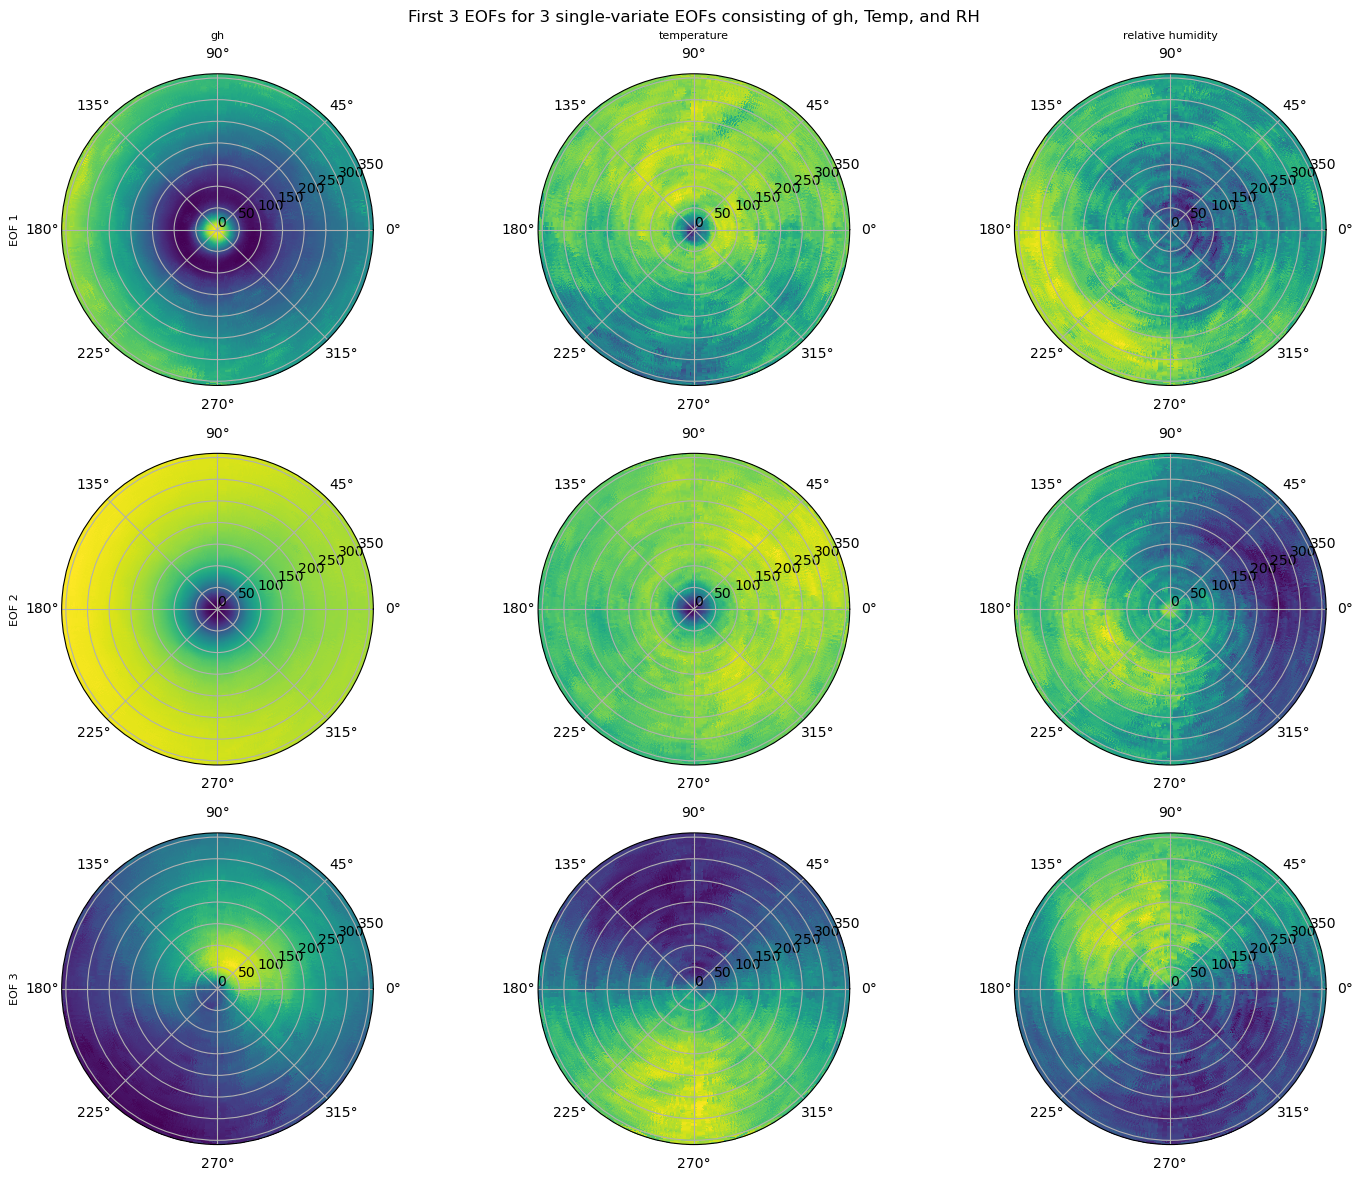

In [245]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_only_eof[0,:,:])
ax[0,1].pcolormesh(R, Theta, t_only_eof[0,:,:])
ax[0,2].pcolormesh(R, Theta, rh_only_eof[0,:,:])
ax[1,0].pcolormesh(R, Theta, gh_only_eof[1,:,:])
ax[1,1].pcolormesh(R, Theta, t_only_eof[1,:,:])
ax[1,2].pcolormesh(R, Theta, rh_only_eof[1,:,:])
ax[2,0].pcolormesh(R, Theta, gh_only_eof[2,:,:])
ax[2,1].pcolormesh(R, Theta, t_only_eof[2,:,:])
ax[2,2].pcolormesh(R, Theta, rh_only_eof[2,:,:])

ax[0,0].set_ylabel('EOF 1', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('EOF 2', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('EOF 3', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('First 3 EOFs for 3 single-variate EOFs consisting of gh, Temp, and RH')

GH Only Scores

In [246]:
scores = cross_val_score(lin_model, gh_only_pcs, center_pressure_clean, scoring = 'neg_mean_squared_error', cv = 7)

rmse_scores = np.sqrt(-scores)
print("RMSE scores: ", rmse_scores)
print("Mean RMSE: ", rmse_scores.mean())
print("RMSE Std: ", rmse_scores.std())



RMSE scores:  [2.08647101 3.58483135 3.07055473 3.52098614 1.96940538 2.18222186
 2.76717845]
Mean RMSE:  2.7402355603508988
RMSE Std:  0.6285717055896664


Temperature Only Scores

In [247]:
scores = cross_val_score(lin_model, t_only_pcs, center_pressure_clean, scoring = 'neg_mean_squared_error', cv = 7)

rmse_scores = np.sqrt(-scores)
print("RMSE scores: ", rmse_scores)
print("Mean RMSE: ", rmse_scores.mean())
print("RMSE Std: ", rmse_scores.std())

RMSE scores:  [10.39245706  8.10698775  8.45112934  7.7430888  11.70977823  7.22907886
  5.4359834 ]
Mean RMSE:  8.438357633393455
RMSE Std:  1.9120173075502958


RH Only Scores

In [248]:
scores = cross_val_score(lin_model, rh_only_pcs, center_pressure_clean, scoring = 'neg_mean_squared_error', cv = 7)

rmse_scores = np.sqrt(-scores)
print("RMSE scores: ", rmse_scores)
print("Mean RMSE: ", rmse_scores.mean())
print("RMSE Std: ", rmse_scores.std())

RMSE scores:  [ 7.86423534  7.49395137 11.96898492 10.19482446 15.84785775  8.6290896
  8.86577019]
Mean RMSE:  10.12353052016691
RMSE Std:  2.7258844677678473
